# Implement Diffusion Model (small one)

## Import framework

In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

c:\Users\mauri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 4    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

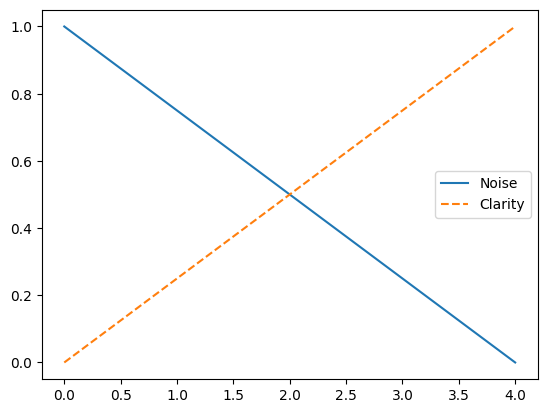

In [7]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity', linestyle="dashed")
plt.legend()

## Import data

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -

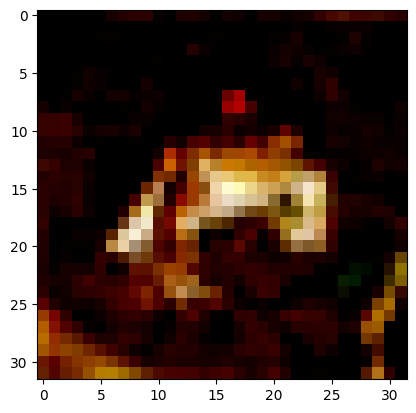

In [31]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

print(all_trainset[0])
#torch.permute(all_trainset[0][0],(1,0,2))
plt.imshow(torch.permute(all_trainset[0][0],(1,2,0)))

## 1_
Look at the data. What is `all_trainset`? Diplay one element of `all_trainset`. Try to print a image 

*Hint: use .permute()*.

## 2_
- Create a list `idx` of idexes of elements of `all_trainset` where the label is a car.
- Then create `sub_trainset` with the class `Subset` from `torch.utils.data`.

In [42]:
inx = []
for el in range (len(all_trainset)):
    if all_trainset[el][1] == 1:
        inx.append(el)


#all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

sub_trainset = torch.utils.data.Subset(all_trainset,inx)
#plt.imshow(torch.permute(sub_trainset[0][0],(1,2,0)))
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

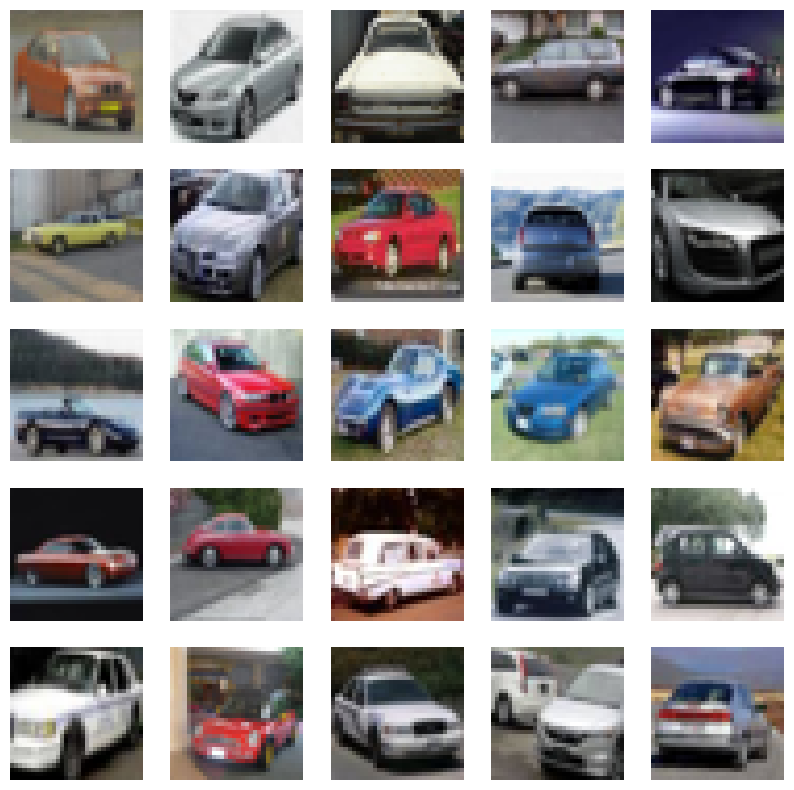

In [48]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

## 3_
Creation of functions.

In [46]:
def forward_noise(x, t):
    """_summary_

    Args:
        x (_type_): images shape (n_images, channels, 32, 32)
        t (_type_): how 

    Returns:
        _type_: _description_
    """
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    # create random noise with the same shape as x
    noise = np.random.random(x.shape)
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

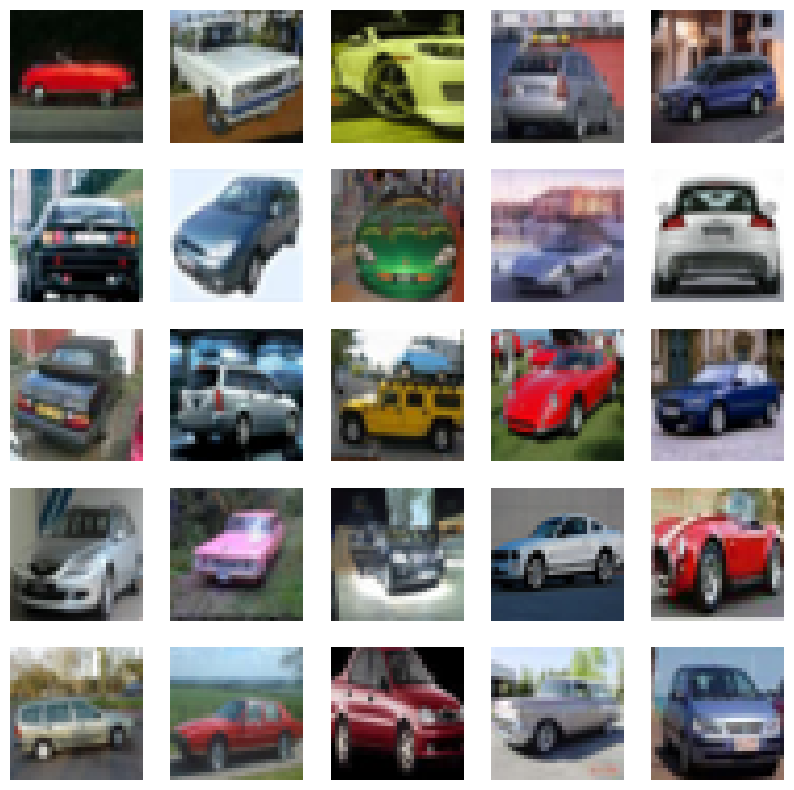

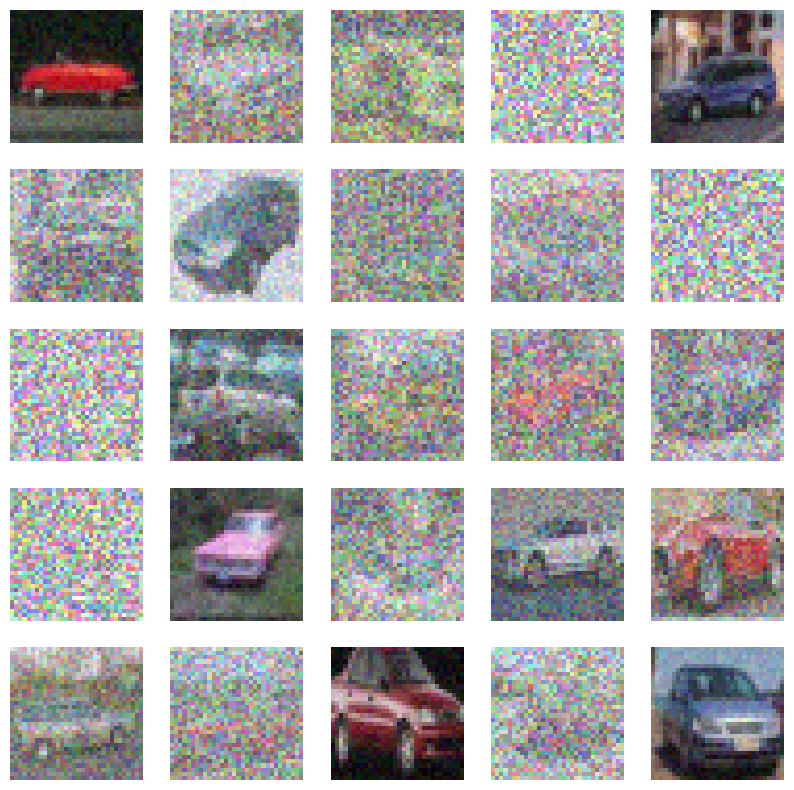

In [50]:
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
show_examples(x[:25])
a, b = forward_noise(x[:25], t)
show_examples(a)